<h1 style="text-align: center; font-size: 50px;">Multimodal RAG Chatbot with Langchain, Torch, Transformers</h1>

Retrieval-Augmented Generation (RAG) is an architectural approach that can enhance the effectiveness of large language model (LLM) applications using customized data. In this example, we use LangChain, an orchestrator for language pipelines, to build an assistant capable of loading information from a web page and use it for answering user questions. We'll leverage torch and transformers for multimodal model support in Python. We'll also use the MLFlow platform to evaluate and trace the LLM responses (in `register-workflow.ipynb`)

# Notebook Overview
- Configuring the Environment
- Data Loading & Cleaning
- Setup Embeddings & Vector Store
- Retrieval Function
- Model Setup & Chain Creation

## Step 0: Configuring the Environment

In this step, we import all the necessary libraries and internal components required to run the RAG pipeline, including modules for notebook parsing, embedding generation, vector storage, and code generation with LLMs.


By using our Local GenAI workspace image, many of the necessary libraries to work with RAG already come pre-installed - in our case, we just need to extra support for multimodal processes.

In [1]:
%pip install -r ../requirements.txt --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
# === Standard Library Imports ===
import gc
import json
import logging
import math
import os
import sys
import time
import hashlib
import shutil
import warnings
import numpy as np
from pathlib import Path
from statistics import mean
from typing import Any, Dict, List, Optional, TypedDict
from IPython.display import display, Markdown

# === Third-Party Library Imports ===
import mlflow
import torch
from langchain_core.embeddings import Embeddings
from langchain.schema.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter, MarkdownHeaderTextSplitter
from langchain.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from PIL import Image as PILImage
from sentence_transformers import CrossEncoder
from transformers import AutoImageProcessor, AutoModel, AutoTokenizer, BitsAndBytesConfig, SiglipModel, SiglipProcessor


# Define the relative path to the 'core' directory (one level up from current working directory)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# === Project-Specific Imports ===
from src.components import SemanticCache, SiglipEmbeddings
from src.wiki_pages_clone import run_wiki_clone
from src.utils import (
    configure_hf_cache,
    load_config,
    display_images,
)

2025-07-27 11:00:02.750574: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-27 11:00:02.763198: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753614002.775298   17418 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753614002.778571   17418 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753614002.788236   17418 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
# Create logger
logger = logging.getLogger("multimodal_rag_logger")
logger.setLevel(logging.INFO)

formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s", datefmt="%Y-%m-%d %H:%M:%S") 
stream_handler = logging.StreamHandler()
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)
logger.propagate = False

In [4]:
start_time = time.time()  

logger.info('Notebook execution started.')

2025-07-27 11:00:04 - INFO - Notebook execution started.


In [5]:
warnings.filterwarnings("ignore")

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")

Using device: cuda



### Verify Assets

In [7]:
CONFIG_PATH = "../configs/config.yaml"

LOCAL_MODEL: Path = Path("/home/jovyan/datafabric/InternVL3-8B-Instruct")
CONTEXT_DIR: Path = Path("../data/context")             
CHROMA_DIR: Path = Path("../data/chroma_store")     
CACHE_DIR: Path = CHROMA_DIR / "semantic_cache"
MANIFEST_PATH: Path = CHROMA_DIR / "manifest.json"

IMAGE_DIR = CONTEXT_DIR / "images"
WIKI_METADATA_DIR = CONTEXT_DIR / "wiki_flat_structure.json"

MLFLOW_EXPERIMENT_NAME = "AIStudio-Multimodal-Chatbot-Experiment"
MLFLOW_RUN_NAME = "AIStudio-Multimodal-Chatbot-Run"
MLFLOW_MODEL_NAME = "AIStudio-Multimodal-Model"

DEMO_FOLDER = "../demo"
MLFLOW_MODEL_NAME = "AIStudio-Multimodal-Chatbot-Model"

In [8]:
def log_asset_status(asset_path: str, asset_name: str, success_message: str, failure_message: str) -> None:
    """
    Logs the status of a given asset based on its existence.

    Parameters:
        asset_path (str): File or directory path to check.
        asset_name (str): Name of the asset for logging context.
        success_message (str): Message to log if asset exists.
        failure_message (str): Message to log if asset does not exist.
    """
    if Path(asset_path).exists():
        logger.info(f"{asset_name} is properly configured. {success_message}")
    else:
        logger.info(f"{asset_name} is not properly configured. {failure_message}")


log_asset_status(
    asset_path=LOCAL_MODEL,
    asset_name="Local Model",
    success_message="",
    failure_message="Please check if the local model was properly configured in your project in your datafabrics folder."
)

log_asset_status(
    asset_path=CONFIG_PATH,
    asset_name="Config",
    success_message="",
    failure_message="Please check if the configs.yaml was properly connfigured in your project on AI Studio."
)

log_asset_status(
    asset_path=WIKI_METADATA_DIR,
    asset_name="wiki_flat_structure.json",
    success_message="",
    failure_message="Place JSON Wiki Pages in data/")

log_asset_status(
    asset_path=CONTEXT_DIR,
    asset_name="CONTEXT",
    success_message="",
    failure_message="Please check if CONTEXT path was downloaded correctly in your project on AI Studio."
)

log_asset_status(
    asset_path=CHROMA_DIR,
    asset_name="CHROMA",
    success_message="",
    failure_message="Please check if CHROMA path was downloaded correctly in your project on AI Studio."
)

log_asset_status(
    asset_path=CACHE_DIR,
    asset_name="CACHE",
    success_message="",
    failure_message="Please check if the CHROMA/CACHE path was properly connfigured in your project on AI Studio."
)


log_asset_status(
    asset_path=MANIFEST_PATH,
    asset_name="MANIFEST",
    success_message="",
    failure_message="Please check if the MANIFEST path was properly connfigured in your project on AI Studio."
)

2025-07-27 11:00:04 - INFO - Local Model is properly configured. 
2025-07-27 11:00:04 - INFO - Config is properly configured. 
2025-07-27 11:00:04 - INFO - wiki_flat_structure.json is properly configured. 
2025-07-27 11:00:04 - INFO - CONTEXT is properly configured. 
2025-07-27 11:00:04 - INFO - CHROMA is properly configured. 
2025-07-27 11:00:04 - INFO - CACHE is properly configured. 
2025-07-27 11:00:04 - INFO - MANIFEST is properly configured. 


### Config Loading

In this section, we load configuration parameters from the YAML file in the configs folder.

- **config.yaml**: Contains non-sensitive configuration parameters like model sources and URLs

In [9]:
config = load_config(CONFIG_PATH)

### Config HuggingFace Caches

In the next cell, we configure HuggingFace cache, so that all the models downloaded from them are persisted locally, even after the workspace is closed. This is a future desired feature for AI Studio and the GenAI addon.

In [10]:
# Configure HuggingFace cache
configure_hf_cache()

In [11]:
%%time

# Initialize HuggingFace Embeddings
embeddings = HuggingFaceEmbeddings(
    model_name="intfloat/e5-large-v2",
    cache_folder="/tmp/hf_cache"
)

CPU times: user 695 ms, sys: 126 ms, total: 821 ms
Wall time: 2.26 s


## Step 1: Data Loading & Cleaning

We load wiki-pages from `wiki_flat_structure.json`, and:
* remove any image name that  
  – is empty / `None`  
  – has an extension not in {png, jpg, jpeg, webp, gif}  
  – points to a file that does **not** exist in `data/images/`
* log every discarded image so we can fix the parser later.

`wiki_flat_structure.json` is a custom json metadata for ADO Wiki data. It is flatly structured, with keys for filepath, md content, and a list of images. We also have a image folder that contains all the images for every md page.

In [12]:
ADO_PAT = os.getenv("AIS_ADO_TOKEN")
ADO_ORG = config.get('AZURE_DEVOPS_ORG')
ADO_PROJECT = config.get('AZURE_DEVOPS_PROJECT')
ADO_WIKI_ID = config.get('AZURE_DEVOPS_WIKI_IDENTIFIER')

# Check if all required configurations are present
if not all([ADO_PAT, ADO_ORG, ADO_PROJECT, ADO_WIKI_ID]):
    logger.warning("SKIPPING ADO WIKI CLONE: Not all required credentials were found.")
    logger.warning("Ensure 'AZURE_DEVOPS_PAT' is set as an environment variable and the ado variables are configured in the config file.")
    logger.warning("The notebook will proceed using existing data in ../data/context, if available.")
else:
    logger.info("Starting ADO Wiki clone process...")
    try:
        # The function will create this directory and place the outputs inside it.
        run_wiki_clone(
            pat=ADO_PAT,
            org=ADO_ORG,
            project=ADO_PROJECT,
            wiki_id=ADO_WIKI_ID,
            output_dir=CONTEXT_DIR,
        )
    except Exception as e:
        logger.error(f"An error occurred during the wiki clone process: {e}", exc_info=True)
        logger.error("Please check your ADO PAT, organization, project, and wiki ID details.")


2025-07-27 11:00:06 - INFO - Starting ADO Wiki clone process...
2025-07-27 11:00:06 - INFO - Cloning wiki 'Phoenix-DS-Platform.wiki' to temporary directory: /tmp/tmp5gb7okeg
2025-07-27 11:00:46 - INFO - Scanning for Markdown files...
2025-07-27 11:00:46 - INFO - → Found 567 Markdown pages.
2025-07-27 11:00:46 - INFO - Copying referenced images to ../data/context/images...
2025-07-27 11:00:53 - INFO - → 738 unique images copied.
2025-07-27 11:00:53 - INFO - Assembling flat JSON structure...
2025-07-27 11:00:53 - INFO - ✅ Wiki data successfully cloned to ../data/context
2025-07-27 11:00:53 - INFO - Cleaned up temporary directory: /tmp/tmp5gb7okeg


In [13]:
%%time

VALID_EXTS = {".png", ".jpg", ".jpeg", ".webp", ".gif"}

WIKI_METADATA_DIR   = Path(WIKI_METADATA_DIR)
IMAGE_DIR = Path(IMAGE_DIR)

def load_mm_docs_clean(json_path: Path, img_dir: Path) -> List[Document]:
    """
    Load wiki Markdown + image references from *json_path*.
    • Filters out images with bad extensions or missing files.
    • Logs the first 20 broken refs.
    • Returns a list[Document] where metadata = {source, images}
    """
    bad_imgs, docs = [], []

    rows = json.loads(json_path.read_text("utf-8"))
    for row in rows:
        images_ok = []
        for name in row.get("images", []):
            if not name: # empty
                bad_imgs.append((row["path"], name, "empty"))
                continue
            ext = Path(name).suffix.lower()
            if ext not in VALID_EXTS: # unsupported ext
                bad_imgs.append((row["path"], name, f"ext {ext}"))
                continue
            img_path = img_dir / name
            if not img_path.is_file(): # missing on disk
                bad_imgs.append((row["path"], name, "missing file"))
                continue
            images_ok.append(name)

        docs.append(
            Document(
                page_content=row["content"],
                metadata={"source": row["path"], "images": images_ok},
            )
        )

    # ---- summary logging ----------------------------------------------------
    if bad_imgs:
        logger.warning("⚠️ %d broken image refs filtered out", len(bad_imgs))
        for src, name, reason in bad_imgs[:20]:
            logger.debug("  » %s → %s (%s)", src, name or "<EMPTY>", reason)
    else:
        logger.info("✅ no invalid image refs found")

    return docs

mm_raw_docs = load_mm_docs_clean(WIKI_METADATA_DIR, Path(IMAGE_DIR))

def log_stage(name: str, docs: List[Document]):
    logger.info(f"{name}: {len(docs)} docs, avg_tokens={sum(len(d.page_content) for d in docs)/len(docs):.0f}")
log_stage("Docs loaded", mm_raw_docs)

2025-07-27 11:00:53 - WARNING - ⚠️ 94 broken image refs filtered out
2025-07-27 11:00:53 - INFO - Docs loaded: 567 docs, avg_tokens=3097


CPU times: user 32.9 ms, sys: 33.5 ms, total: 66.5 ms
Wall time: 681 ms


## Step 2: Creation of Chunks

Here, we split the loaded documents into chunks, so we have smaller and more specific texts to add to our vector database. 

We chunk based on header style, and then within each header style we futher chunk based on the provided chunk size. Each chunk retains the page name, which preserves the relevance of each chunk. 

In [14]:
%%time

def chunk_documents(
    docs,
    chunk_size: int = 1200,
    overlap: int = 200,
) -> list[Document]:
    """
    1) Split each wiki page on Markdown headers (#, ## …) to keep logical
       sections together.
    2) Recursively break long sections to <= `chunk_size` chars with `overlap`.
    3) Prefix every chunk with its page-title and store the title in metadata.
    """
    header_splitter = MarkdownHeaderTextSplitter(
        headers_to_split_on=[("#", "title"), ("##", "section")]
    )
    recursive_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=overlap,
    )

    all_chunks: list[Document] = []
    for doc in docs:
        page_title = Path(doc.metadata["source"]).stem.replace("-", " ")

        # 1️. section‑level split (returns list[Document])
        section_docs = header_splitter.split_text(doc.page_content)

        for section in section_docs:
            # 2. size‑based split inside each section
            tiny_texts = recursive_splitter.split_text(section.page_content)

            for idx, tiny in enumerate(tiny_texts):
                all_chunks.append(
                    Document(
                        page_content=f"{page_title}\n\n{tiny.strip()}",
                        metadata={
                            "title": page_title,
                            "source": doc.metadata["source"],
                            "section_header": section.metadata.get("header", ""),
                            "chunk_id": idx,
                        },
                    )
                )
    if all_chunks:
        avg_len = int(mean(len(c.page_content) for c in all_chunks))
        logger.info(
            "Chunking complete: %d docs → %d chunks (avg %d chars)",
            len(docs),
            len(all_chunks),
            avg_len,
        )
    else:
        logger.warning("Chunking produced zero chunks for %d docs", len(docs))

    return all_chunks

splits = chunk_documents(mm_raw_docs)

2025-07-27 11:00:54 - INFO - Chunking complete: 567 docs → 2614 chunks (avg 717 chars)


CPU times: user 70.3 ms, sys: 685 μs, total: 71 ms
Wall time: 67.2 ms


## Step 3: Setup Embeddings & Vector Store
Here we setup Siglip for Image embeddings, and also transform our cleaned text chunks into embeddings to be stored in Chroma. We store the chroma data locally on the disk to reduce memory usage. 

### Setup Text ChromaDB

In [15]:
%%time

# 1) TEXT store
def _current_manifest() -> Dict[str, str]:
    """
    Returns a dictionary mapping every context JSON file to its SHA256 content hash.
    This allows detecting changes in file content, not just filenames.
    """
    manifest = {}
    json_files = sorted(CONTEXT_DIR.rglob("*.json"))

    for file_path in json_files:
        try:
            with open(file_path, "rb") as f:
                file_bytes = f.read()
                file_hash = hashlib.sha256(file_bytes).hexdigest()
                manifest[str(file_path.resolve())] = file_hash
        except IOError as e:
            logger.error(f"Could not read file {file_path} for hashing: {e}")
    return manifest

def _needs_rebuild() -> bool:
    """
    Determines if the ChromaDB needs to be rebuilt.
    A rebuild is needed if:
    1. The Chroma directory or manifest file doesn't exist.
    2. The manifest is unreadable.
    3. The stored file hashes in the manifest do not match the current file hashes.
    """
    if not CHROMA_DIR.exists() or not MANIFEST_PATH.exists():
        logger.info("Chroma directory or manifest not found. A rebuild is required.")
        return True
    try:
        old_manifest = json.loads(MANIFEST_PATH.read_text())
    except Exception as e:
        logger.warning(f"Could not read manifest file. A rebuild is required. Error: {e}")
        return True

    current_manifest = _current_manifest()
    if old_manifest != current_manifest:
        logger.info("Data content has changed. A rebuild is required.")
        return True

    return False

def _save_manifest(manifest: Dict[str, str]) -> None:
    """Saves the current data manifest (mapping file paths to hashes) to disk."""
    CHROMA_DIR.mkdir(parents=True, exist_ok=True)
    MANIFEST_PATH.write_text(json.dumps(manifest, indent=2))

def _build_text_db() -> Chroma:
    collection = "mm_text"
    # The rebuild check is now done outside this function.
    # We check if the directory exists. If not, we build.
    if not CHROMA_DIR.exists() or not (CHROMA_DIR / "chroma.sqlite3").exists():
        logger.info("Creating new text context index in %s ...", CHROMA_DIR)
        chroma = Chroma.from_documents(
            documents          = splits,
            embedding          = embeddings,
            collection_name    = collection,
            persist_directory  = str(CHROMA_DIR),
        )
        return chroma

    logger.info("Loading existing Chroma index from %s", CHROMA_DIR)
    return Chroma(
        collection_name   = collection,
        persist_directory = str(CHROMA_DIR),
        embedding_function= embeddings,
    )
    
# Check if a rebuild is needed and wipe the old DB if so.
# This ensures both the text and image databases are rebuilt from scratch.
if _needs_rebuild():
    logger.warning("REBUILDING: Wiping old ChromaDB store at %s", CHROMA_DIR)
    if CHROMA_DIR.exists():
        shutil.rmtree(CHROMA_DIR)
    # Save the new manifest immediately after deciding to rebuild
    _save_manifest(_current_manifest())

# Now, initialize your databases. They will be created fresh if they were just deleted.
text_db = _build_text_db()

2025-07-27 11:00:54 - INFO - Loading existing Chroma index from ../data/chroma_store


CPU times: user 172 ms, sys: 13.9 ms, total: 186 ms
Wall time: 241 ms


### Setup Image ChromaDB

In [16]:
%%time

#  Helper: walk all docs once and gather *unique* image vectors + metadata
def _collect_image_vectors():
    """
    Scans every wiki page for image references and returns three parallel lists:
        img_paths : list[str]   → full file-system paths (for SigLIP)
        img_ids   : list[str]   → unique key per (page, image) pair
        img_meta  : list[dict]  → {"source": wiki_page, "image": file_name}
    Runs in < 1s even for thousands of docs.
    """
    img_paths, img_ids, img_meta = [], [], []
    seen = set()

    for doc in mm_raw_docs:                         # raw wiki pages
        src = doc.metadata["source"]
        for name in doc.metadata.get("images", []): # list[str]
            img_id = f"{src}::{name}"
            if img_id in seen:
                continue                            # de‑dupe
            seen.add(img_id)

            img_paths.append(str(IMAGE_DIR / name))
            img_ids.append(img_id)
            img_meta.append({"source": src, "image": name})

    return img_paths, img_ids, img_meta

siglip_embeddings = SiglipEmbeddings("google/siglip2-base-patch16-224", DEVICE)

# 2) IMAGE store
image_db = Chroma(
    collection_name    = "mm_image",
    persist_directory  = str(CHROMA_DIR),   # SAME dir as text db
    embedding_function = siglip_embeddings, # <-- class you kept
)

# Populate vectors *only* if it is empty
if not image_db._collection.count():
    img_paths, img_ids, img_meta = _collect_image_vectors()
    image_db.add_texts(texts=img_paths, metadatas=img_meta, ids=img_ids)
    image_db.persist()
    logger.info("Indexed %d unique images.", len(img_paths))
else:
    logger.info("Loaded existing image index (%d vectors).",
                image_db._collection.count())


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
2025-07-27 11:00:57 - INFO - Loaded existing image index (752 vectors).


CPU times: user 1.89 s, sys: 231 ms, total: 2.12 s
Wall time: 3.09 s


### Setup Memory Store

In [17]:
# Initialize the semantic cache
semantic_cache = SemanticCache(persist_directory=CACHE_DIR, embedding_function=embeddings)

## Step 4: Retrieval Function

This code implements a multi-stage retrieval process that combines vector similarity search, cross-encoder reranking, and a hybrid scoring mechanism to select the most relevant text documents and associated images.

Here, the system performs an initial similarity search against a `text_db` (likely a vector store like ChromaDB, given your imports). It uses the `query` to find the top `fetch_k` most similar text documents based on their initial embedding similarity. This step acts as a broad filter, quickly identifying a larger set of potentially relevant documents. The result includes both the documents `(docs)` and their initial similarity scores (init_scores). After the intial recall, we use a cross-encoder to rerank these `fetch_k` documents. Unlike the initial embedding similarity, a cross-encoder takes the query and each document content as a pair and provides a more nuanced relevance score by considering their interaction. We also implement Hybrid scoring and select the `top-k` documents at the end.

Using the `top-k` documents, we retrieve images associated with those documents.



In [18]:
def retrieve_mm(
    query: str,
    k_txt: int = 4,
    k_img: int = 8,
    fetch_k: int = 20,
    hybrid_weights: Dict[str, float] = {"init": 0.4, "rerank": 0.6},
    boost_slug: float = 0.1,
) -> Dict[str, Any]:
    """
    1) Coarse recall: top `fetch_k` docs + init_scores
    2) On-demand load cross-encoder, rerank, and unload
    3) Build hybrid_score = w1*init + w2*rerank + optional slug boost
    4) Sort by hybrid_score, then pick top-k_txt
    5) Image retrieval with $in filter
    """
    # 1) Coarse recall
    docs_and_init = text_db.similarity_search_with_score(query, k=fetch_k)
    docs, init_scores = zip(*docs_and_init)

    # 2) Rerank (On-demand load/unload)
    rerank_scores = []
    if docs:
        logger.info("Loading cross-encoder to GPU for reranking...")
        cross_encoder = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2", device=device)
        pairs = [(query, d.page_content) for d in docs]
        rerank_scores = cross_encoder.predict(pairs)
        
        # --- UNLOAD THE MODEL AND CLEAR VRAM ---
        logger.info("Unloading cross-encoder and clearing cache...")
        del cross_encoder
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            
    # 3) Compute hybrid scores (+ slug boost)
    slug = query.lower().replace(" ", "-")
    hybrid_scores = []
    for d, init, rerank in zip(docs, init_scores, rerank_scores):
        score = hybrid_weights["init"] * init + hybrid_weights["rerank"] * rerank
        if slug in d.metadata.get("source", "").lower():
            score += boost_slug
        hybrid_scores.append(score)
    # 4) select top‑k_txt
    scored_docs = list(zip(docs, hybrid_scores))
    scored_docs.sort(key=lambda x: x[1], reverse=True)

    top_docs_and_scores = scored_docs[:k_txt]

    if not top_docs_and_scores:
        return {"docs": [], "images": [], "scores": []}
    selected_docs, final_scores = zip(*top_docs_and_scores)

    # 5) Image retrieval
    sources = [d.metadata["source"] for d in selected_docs]
    q_emb = siglip_embeddings.embed_query(query)
    img_hits = image_db.similarity_search_by_vector(
        q_emb,
        k=k_img * 2,
        filter={"source": {"$in": sources}},
    )
    images = [img.page_content for img in img_hits[:k_img]]

    return {
        "docs": list(selected_docs),
        "images": images,
        "scores": list(final_scores),
    }

## Step 5: Model Setup & Chain Creation

In this section, we set up our local Large Language Model (LLM) and integrate it into a Question Answering (QA) pipeline. We're using `internvl3-8b-instruct` as our multimodal model, which can process both text and images. This setup is encapsulated within the InternVLMM class, designed for efficient and robust multimodal interactions.

### System Prompt

In [19]:
SYSTEM_PROMPT = """
    You are AI Studio DevOps Assistant. Your function is to analyze images and text, then answer questions based ONLY on the provided materials.
    
    **PERMANENT INSTRUCTIONS:**
    1.  **Analyze and Answer from Context**: Your entire response MUST be derived thoroughly from the provided `<context>` block or the user's image(s).
    2.  **Follow Output Structure**: You MUST follow the multi-part response structure outlined in the user's message. Completing all sections is mandatory.
    3.  **No External Knowledge**: You MUST NOT use any information outside the provided materials.
    4.  **No Hallucination**: Do not invent or assume any details. If information is not present, it does not exist.
    5.  **Handle Missing Information**: If the provided context or image(s) do not contain the answer, your ONLY response will be: "Based on the provided context, I cannot answer this question." Do not add any other words or explanation.
    """

### InternVLMM QA Wrapper

In [20]:
%%time


class InternVLMM:
    """
    Minimal, self-contained multimodal QA wrapper around InternVL3-8B-Instruct.
    This class:
      • loads / resets the model
      • builds the prompt (<context>…)
      • returns the model's answer (based on img and text) and also the top retrieved images
    """

    def __init__(self, cache: SemanticCache):
        self.tok   = None
        self.image_processor = None
        self.cache = cache
        self._load()

    # ---------- public function ----------
    def generate(self, query: str, force_regenerate: bool = False, **retrieval_kwargs) -> Dict[str, Any]:
        """
        Run retrieval, prompt assembly, and model generation.
        Returns a dictionary with the text reply and a list of used image paths.
        """
        
        # === 1. CHECK SEMANTIC CACHE (or bypass if forced) ===
        if not force_regenerate:
            cached_result = self.cache.get(query, threshold=0.92)
            if cached_result:
                logger.info(f"SEMANTIC CACHE HIT for query: '{query}'")
                return cached_result
        
        if force_regenerate:
            logger.info(f"Forced regeneration for query: '{query}'. Clearing old cache entry.")
            self.cache.delete(query)

        logger.info(f"CACHE MISS for query: '{query}'. Running full pipeline.")
        if self.model is None or self.tok is None:
            return {"reply": "Error: model not initialised.", "used_images": []}
    
        # === 2. RETRIEVE (if not cached) ===
        hits = retrieve_mm(query, **retrieval_kwargs)
        docs: List[Any]   = hits["docs"]
        images: List[str] = hits["images"] # This is the list of paths you want to return
    
        if not docs and not images:
            return {"reply": "I don't know based on the provided context.", "used_images": []}

        # === 3. BUILD PROMPT & GENERATE ===
        context_str = "\n\n".join(
            f"<source_document name=\"{d.metadata.get('source', 'unknown')}\">\n{d.page_content}\n</source_document>"
            for d in docs
        )
        
        # Combine the response structure and query into the user message.
        visual_analysis_prompt = ""
        if images:
            visual_analysis_prompt = """
            ## **Visual Analysis**\n
            """
        
        # Construct the final prompt
        user_content = f"""
            <task_instructions>
            Your response must follow this exact structure:
            {visual_analysis_prompt}
            ## **Synthesized Answer**\n
            Next, answer the user's original query. Your answer must be synthesized from the provided text `<context>`. Use the visual analysis only if it is relevant. If the image is not relevant, rely solely on the text context to formulate your answer.\n
            
            ## **Source Documents**\n
            At the very end of your response, cite the source from the context in brackets and backticks, like this: [`source-file-name.md`].\n
            
            </task_instructions>
    
            <context>
                {context_str}
            </context>
    
            <user_query>
                 {query}
            </user_query>
    
            Now, generate the response following all instructions.
            """

        # Construct the conversation history as a list of dictionaries
        conversation = [
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": user_content}
        ]
        
        # Apply the chat template
        prompt = self.tok.apply_chat_template(
            conversation,
            tokenize=False,
            add_generation_prompt=True
        )
                
        if images:
            prompt += f"\n\n[{len(images)} image(s) are provided for analysis]"

        # generate
        try:
            self._clear_cuda()
            pixel_values = self._process_images(images) if images else None
            reply = self.model.chat(
                self.tok, pixel_values, prompt,
                generation_config=dict(
                    max_new_tokens=16384, 
                    pad_token_id=self.tok.pad_token_id, 
                    eos_token_id=self.tok.eos_token_id,
                    repetition_penalty=1.10,
                    # --- Add these lines for creative sampling ---
                    do_sample=True,         # This is required to enable sampling
                    temperature=0.3,        # Controls randomness. Lower is more predictable, higher is more creative.
                    top_p=0.9,              # Nucleus sampling: considers the smallest set of tokens whose cumulative probability exceeds top_p.
                ),
            )
            self._clear_cuda()

            result_dict = {"reply": reply, "used_images": images}
            
            # === 4. UPDATE CACHE ===
            self.cache.set(query, result_dict)
            
            return result_dict

        except RuntimeError as e:
            msg = str(e).lower()
            if "cuda" in msg or "out of memory" in msg:
                logger.warning("CUDA error – resetting model: %s", e)
                self._reset()
                error_reply = "I ran into a GPU memory error – please try again."
            else:
                logger.error("Runtime error: %s", e)
                error_reply = f"Error: {e}"
            return {"reply": error_reply, "used_images": images}
            
    # ---------- internal helpers ----------
    
    def _load(self):
        """Load tokenizer, image_processor, & model. Handles 4-bit quant on GPUs, fp32 on CPU."""
        logger.info("Loading %s ...", LOCAL_MODEL)
        gc.collect()
        self._clear_cuda()

        self.tok = AutoTokenizer.from_pretrained(
            LOCAL_MODEL, trust_remote_code=True
        )
        if self.tok.pad_token is None:
            self.tok.pad_token = self.tok.eos_token

        self.image_processor = AutoImageProcessor.from_pretrained(
            LOCAL_MODEL, trust_remote_code=True, use_fast=True
        )

        q_cfg = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4", # Use the modern "Normal Float 4"
            bnb_4bit_compute_dtype=torch.bfloat16, # Speeds up computation
            bnb_4bit_use_double_quant=True, # Minor memory improvement
        )

        self.model = AutoModel.from_pretrained(
            LOCAL_MODEL,
            quantization_config=q_cfg,
            torch_dtype=(torch.bfloat16 if DEVICE == "cuda" else torch.float32),
            low_cpu_mem_usage=True,
            use_flash_attn=False,
            trust_remote_code=True,
            device_map="auto" if DEVICE == "cuda" else None,
        ).eval()
        logger.info("Model loaded on %s.", DEVICE)

    def _reset(self):
        """Free everything and reload (called after persistent CUDA errors)."""
        logger.warning("Resetting InternVL model …")
        del self.model, self.tok, self.image_processor
        self.model = self.tok = self.image_processor = None
        gc.collect()
        self._clear_cuda()
        time.sleep(1)
        self._load()

    def _process_images(self, image_paths: List[str]):
        """
        Convert a list of image filepaths to a single batched tensor.
        """
        if not image_paths:
            return None
        try:
            # Open all images from their file paths
            pil_images = [PILImage.open(p).convert("RGB") for p in image_paths]
            
            # The processor naturally handles a list of PIL images
            processed_data = self.image_processor(images=pil_images, return_tensors="pt")
            pixel_values = processed_data['pixel_values']

            # Match model device/dtype
            target_dtype = next(self.model.parameters()).dtype if self.model else torch.float32
            pixel_values = pixel_values.to(device=DEVICE, dtype=target_dtype)
            
            return pixel_values
            
        except Exception as e:
            logger.error("Image processing failed for one or more images: %s", e)
            return None

    @staticmethod
    def _clear_cuda():
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.synchronize()

# Initalize mm llm
mm = InternVLMM(semantic_cache)

2025-07-27 11:00:57 - INFO - Loading /home/jovyan/datafabric/InternVL3-8B-Instruct ...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

2025-07-27 11:02:14 - INFO - Model loaded on cuda.


CPU times: user 8.74 s, sys: 13.7 s, total: 22.4 s
Wall time: 1min 16s


## Step 6: Test Generation and Outputs

2025-07-27 11:02:14 - INFO - Forced regeneration for query: 'How do i run blueprints locally?'. Clearing old cache entry.
2025-07-27 11:02:14 - INFO - CACHE MISS for query: 'How do i run blueprints locally?'. Running full pipeline.
2025-07-27 11:02:14 - INFO - Loading cross-encoder to GPU for reranking...
2025-07-27 11:02:16 - INFO - Unloading cross-encoder and clearing cache...
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


--- MODEL RESPONSE ---
## **Visual Analysis**

The image shows a screenshot of an error message from AWS CloudFront, indicating that the service is unable to get AWS session. This suggests there might be issues with authentication or permissions when running blueprints locally.

## **Synthesized Answer**

To run blueprints locally, follow these steps:

1. **AWS Login**: Ensure you are logged in with the correct account.
2. **Disable Migration and AWS Key Manager**: Adjust settings in `app\cloud\main.go` and `business\sys\container\container.go`.
3. **Create Local `.env` File**:
   - Under the `phoenix-app-backend` repo, create a local `.env` file with the following details:
     ```plaintext
     DB_TYPE=inmemory
     DB_USER=root
     DB_PASS=password
     DB_NAME=phoenix-backend-dev
     RBAC_DB_NAME=phoenix-rbac-dev
     AUTH_MECHANISM=local
     HPOC_ROOT_ORG_ID=5d6b184d-70ed-3bd1-8dbd-36a0bb3ea220
     HPOC_API_CLIENT_ID=a540ec5d-ddab-4521-8289-e2bc71662d2d
     HPOC_API_CLIENT_SE

## **Visual Analysis**

The image shows a screenshot of an error message from AWS CloudFront, indicating that the service is unable to get AWS session. This suggests there might be issues with authentication or permissions when running blueprints locally.

## **Synthesized Answer**

To run blueprints locally, follow these steps:

1. **AWS Login**: Ensure you are logged in with the correct account.
2. **Disable Migration and AWS Key Manager**: Adjust settings in `app\cloud\main.go` and `business\sys\container\container.go`.
3. **Create Local `.env` File**:
   - Under the `phoenix-app-backend` repo, create a local `.env` file with the following details:
     ```plaintext
     DB_TYPE=inmemory
     DB_USER=root
     DB_PASS=password
     DB_NAME=phoenix-backend-dev
     RBAC_DB_NAME=phoenix-rbac-dev
     AUTH_MECHANISM=local
     HPOC_ROOT_ORG_ID=5d6b184d-70ed-3bd1-8dbd-36a0bb3ea220
     HPOC_API_CLIENT_ID=a540ec5d-ddab-4521-8289-e2bc71662d2d
     HPOC_API_CLIENT_SECRET=6C11RH3Cq8cInp3ROx15F3vH3YH3XnWaeIhqTW0ii86zd8aeLs3il2mT02im
     HPOC_API_CONFIG_ID=4496b334-3996-3c2b-81d2-3b5d8a22993f
     ```
4. Run the app using VS Code task -> "Cloud: Debug Windows`.

![image](/.attachments/image-ac825230-29f3-4251-aac2-2f1b48e9921a.png)

## **Source Documents**
[How-to-run-blueprints-locally.md]

----------------------

🖼️ Displaying 5 image(s):


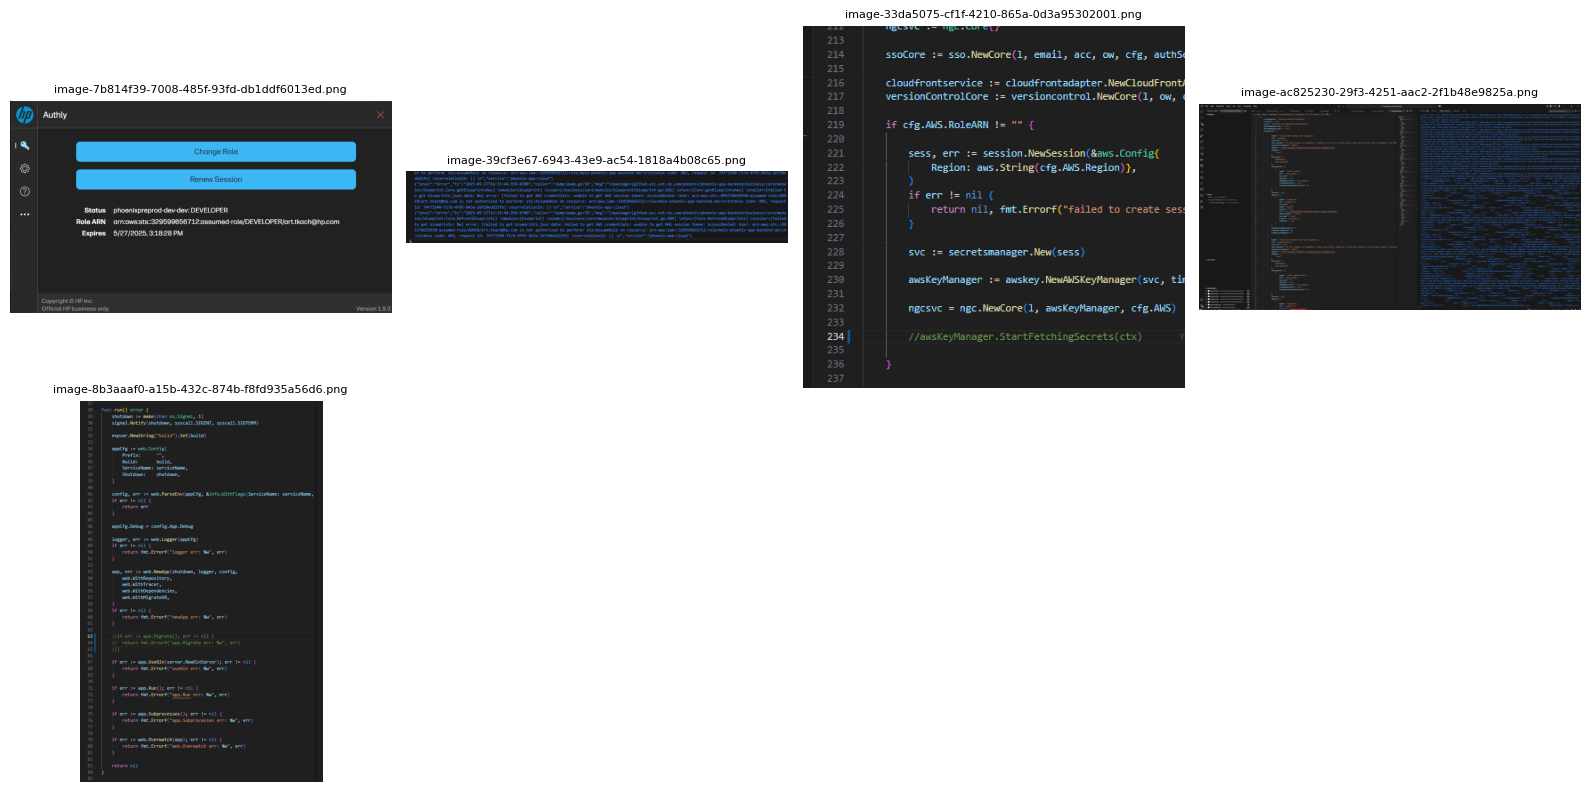

CPU times: user 25.1 s, sys: 4.5 s, total: 29.6 s
Wall time: 29.6 s


In [21]:
%%time

question = "How do i run blueprints locally?"
results = mm.generate(question, force_regenerate=False)

print("--- MODEL RESPONSE ---")
display(Markdown(results["reply"]))
print("----------------------\n")

display_images(results["used_images"])

In [22]:
%%time

question2 = "What are some feature flags in AIStudio?"
results = mm.generate(question2, force_regenerate=False)

print("--- MODEL RESPONSE ---")
display(Markdown(results["reply"]))
print("----------------------\n")

display_images(results["used_images"])

2025-07-27 11:02:43 - INFO - SEMANTIC CACHE HIT for query: 'What are some feature flags in AIStudio?'


--- MODEL RESPONSE ---


## **Synthesized Answer**

### Some the feature flags in AIStudio, based on the provided context, are:

- `azure`
- `gcp`
- `ngc`

These flags enable or disable specific features such as Azure and GCP datasets integration. They can be managed using the command-line tool `hooh`, which requires a signed file stored at `%localappdata%/HP/AIStudio/features.yaml`.

## **Source Documents**

[`Feature-Flags.md`]

----------------------

▶ No images to display.
CPU times: user 14.1 ms, sys: 4.94 ms, total: 19.1 ms
Wall time: 21.6 ms


In [ ]:
%%time

question3 = "How do i manually clean my environment without hooh?"
results = mm.generate(question3, force_regenerate=True)

print("--- MODEL RESPONSE ---")
display(Markdown(results["reply"]))
print("----------------------\n")

display_images(results["used_images"])

2025-07-27 11:02:43 - INFO - Forced regeneration for query: 'How do i manually clean my environment without hooh?'. Clearing old cache entry.
2025-07-27 11:02:43 - INFO - CACHE MISS for query: 'How do i manually clean my environment without hooh?'. Running full pipeline.
2025-07-27 11:02:43 - INFO - Loading cross-encoder to GPU for reranking...
2025-07-27 11:02:46 - INFO - Unloading cross-encoder and clearing cache...


In [ ]:
%%time

question4 = "How do i sign a config file?"
results = mm.generate(question4, force_regenerate=True)

print("--- MODEL RESPONSE ---")
display(Markdown(results["reply"]))
print("----------------------\n")

display_images(results["used_images"])

In [ ]:
end_time: float = time.time()
elapsed_time: float = end_time - start_time
elapsed_minutes: int = int(elapsed_time // 60)
elapsed_seconds: float = elapsed_time % 60

logger.info(f"⏱️ Total execution time: {elapsed_minutes}m {elapsed_seconds:.2f}s")
logger.info("✅ Notebook execution completed successfully.")

Built with ❤️ using Z by HP AI Studio.